In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import redback
from bilby.core.prior import Uniform, Gaussian, LogUniform, PriorDict
from astropy.cosmology import Planck18 as cosmo
import bilby
import redback.transient_models.spectral_models as sm

11:27 bilby INFO    : Running bilby version: 2.3.1.dev58+g0d4b91f3
11:27 redback INFO    : Running redback version: 1.0.31


In [2]:
temp = 5800 
rph = 1e13
redshift = 0.01
lc1 = 6800
ls1 = 1e-31
v1 = 0.02 * 3e8
lc2 = 4400
ls2 = 8e-32
v2 = 0.05*3e8
angstroms = np.geomspace(2000, 9000, 300)

injection_parameters = {"temp":temp, "rph":rph, "redshift":redshift, "lc1":lc1, "ls1":ls1, 
                        "v1":v1, "lc2":lc2, "ls2":ls2, "v2":v2}

# let's generate fake fluxes by using a spectral model within redback
# This could be any function that can output a spectrum within redback or a user-defined function.
func = sm.blackbody_spectrum_with_absorption_and_emission_lines
flux = func(angstroms, redshift, rph, temp, lc1, ls1, v1, lc2, ls2, v2)
sigmas = 0.10*flux
errors = np.random.normal(0, sigmas, len(flux))
obs_flux = flux + errors

In [3]:
spec = redback.transient.Spectrum(angstroms=angstroms, 
                                  flux_density=obs_flux, 
                                 flux_density_err=sigmas, 
                                 name='SN2025axg', time=None)

lets plot and mark the location of the lines, we also pass some other kwargs for visual changes. You could also do these handling the matplotlib axes 



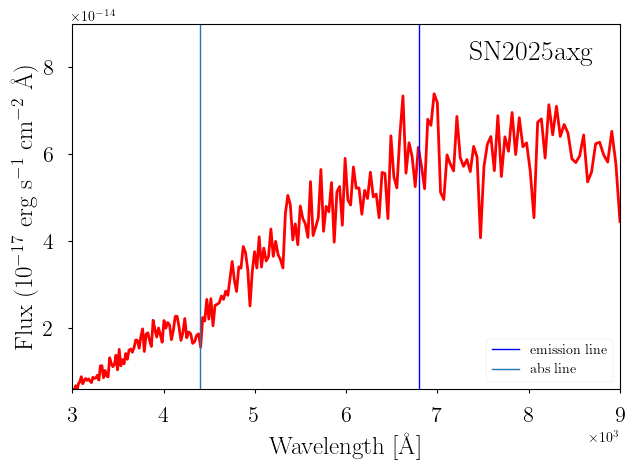

In [4]:
ax = spec.plot_data(yscale='linear', ylim_low=6e-15, 
                    ylim_high=9e-14,color='red', show=False)
ax.axvline(lc1, label='emission line', c='blue')
ax.axvline(lc2, label='abs line')

# lets change the matplotlib x axes limits directly instead of a kwarg
ax.set_xlim(3000, 9000)
ax.legend()


We can now set up a prior and sample or get a max-likelihood estimate.

Let's get a max likelihood estimate first.

In [5]:
# We first set up a likelihood and prior 

# Let's set up a prior first using the default prior for this model in redback 
# but modifying some specific priors

priors = redback.priors.get_priors('blackbody_spectrum_with_absorption_and_emission_lines')
priors['redshift'] = injection_parameters['redshift']
priors['ls1'] = Gaussian(ls1, 0.1*ls1, 'ls1')
priors['ls2'] = Gaussian(ls2, 0.2*ls1, 'ls1')
priors['lc1'] = Uniform(6000, 7000, 'lc1')
priors['lc2'] = Uniform(4000, 5000, 'lc1')
priors['v1'] = Gaussian(v1, 0.01*v1, 'v1')
priors['v2'] = Gaussian(v2, 0.1*v2, 'v2')
likelihood = redback.likelihoods.GaussianLikelihood(x=angstroms, y=obs_flux, sigma=0.125*flux, 
                                                    function=func, priors=priors, fiducial_parameters=priors.sample())

Let's use redback likelihood's default functionality to find the maximum likelihood point. 

Note that finding max likelihood, unlike sampling is sensitive to the initial guess set by the fiducial parameters. You will either need to set a targeted prior for this or be willing to run it a few times.

In [6]:
maxl = likelihood.find_maximum_likelihood_parameters(iterations=10)

11:27 redback INFO    : Optimizing fiducial parameters. Iteration : 1
11:27 redback INFO    : Current lnlikelihood: 9504.10
11:27 redback INFO    : Updated parameters: {'rph': 10000000000000.0, 'temp': 5790.503416184594, 'lc1': 6818.532665061666, 'lc2': 4391.365940513522, 'ls1': 1.1476536350968855e-31, 'ls2': 7.87458732380679e-32, 'v1': 6958668.882343415, 'v2': 12583609.169028256, 'redshift': 0.01}
11:27 redback INFO    : Optimizing fiducial parameters. Iteration : 2
11:27 redback INFO    : Current lnlikelihood: 9505.52
11:27 redback INFO    : Updated parameters: {'rph': 10000000778510.11, 'temp': 5791.360015446906, 'lc1': 6804.448616700676, 'lc2': 4391.632646415448, 'ls1': 6.688307551226043e-32, 'ls2': 8.038709369038421e-32, 'v1': 9299395.041005336, 'v2': 12503687.801065423, 'redshift': 0.01}
11:27 redback INFO    : Optimizing fiducial parameters. Iteration : 3
11:27 redback INFO    : Current lnlikelihood: 9505.52
11:27 redback INFO    : Updated parameters: {'rph': 10000000000136.889,

Let's plot the max likelihood estimate on our data and see how we fared

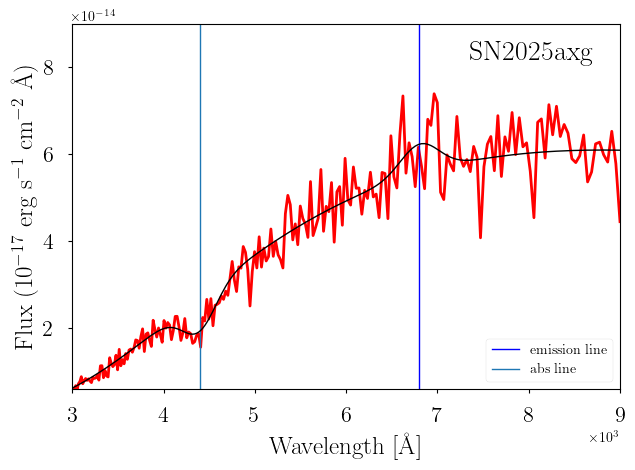

In [7]:
ax = spec.plot_data(yscale='linear', ylim_low=6e-15, 
                    ylim_high=9e-14,color='red', show=False)
ax.axvline(lc1, label='emission line', c='blue')
ax.axvline(lc2, label='abs line')
ax.set_xlim(3000, 9000)
ax.legend()

# I can plot the maxl estimate directly on top of the plot_data plot here
out = func(angstroms, **maxl)
ax.plot(angstroms, out/1e-17, color='black')

Not too bad! But we are Bayesians... we dont want just a max likelihood, when we can have the posterior!! Also, we don't want to be as susceptible to the choice of prior

In [8]:
# We have the likelihood and prior already specified, so all we need now run the sampler within redback

result = redback.fit_model(spec, model=func, likelihood=likelihood, prior=priors, 
                           sampler='nestle', nlive=200, clean=True, 
                           injection_parameters=injection_parameters, plot=False)

11:27 redback INFO    : No kwargs passed to function
11:27 bilby INFO    : Running for label 'SN2025axg', output will be saved to 'spectrum//blackbody_spectrum_with_absorption_and_emission_lines'
11:27 bilby WARNING : Parameter fiducial has no default prior and is set to 0, this will not be sampled and may cause an error.
11:27 bilby INFO    : Analysis priors:
11:27 bilby INFO    : rph=LogUniform(minimum=10000000000000.0, maximum=1e+16, name='rph', latex_label='$R_{\\mathrm{ph}}~(\\mathrm{cm})$', unit=None, boundary=None)
11:27 bilby INFO    : temp=Uniform(minimum=1000.0, maximum=100000.0, name='temp', latex_label='$T~(\\mathrm{K})$', unit=None, boundary=None)
11:27 bilby INFO    : lc1=Uniform(minimum=6000, maximum=7000, name='lc1', latex_label='lc1', unit=None, boundary=None)
11:27 bilby INFO    : lc2=Uniform(minimum=4000, maximum=5000, name='lc1', latex_label='lc1', unit=None, boundary=None)
11:27 bilby INFO    : ls1=Gaussian(mu=1e-31, sigma=1.0000000000000002e-32, name='ls1', latex_

it=  4143 logz=21536.1865008716875399500000000000


11:28 bilby INFO    : Sampling time: 0:00:21.553082
11:28 bilby INFO    : Summary of results:
nsamples: 4344
ln_noise_evidence: 12052.071
ln_evidence: 21536.410 +/-  0.295
ln_bayes_factor: 9484.339 +/-  0.295



Let's plot the spectrum PPD

(3000.0, 9000.0)

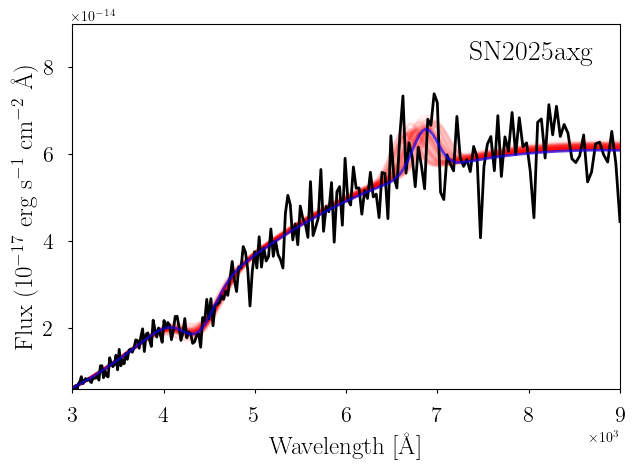

In [11]:
ax = result.plot_spectrum(yscale='linear', ylim_low=6e-15, 
                    ylim_high=9e-14,color='black', show=False)
ax.set_xlim(3000, 9000)



We can also plot the corner plot, which will show what our posterior looks like compared to the truth (injection parameters shown in orange)

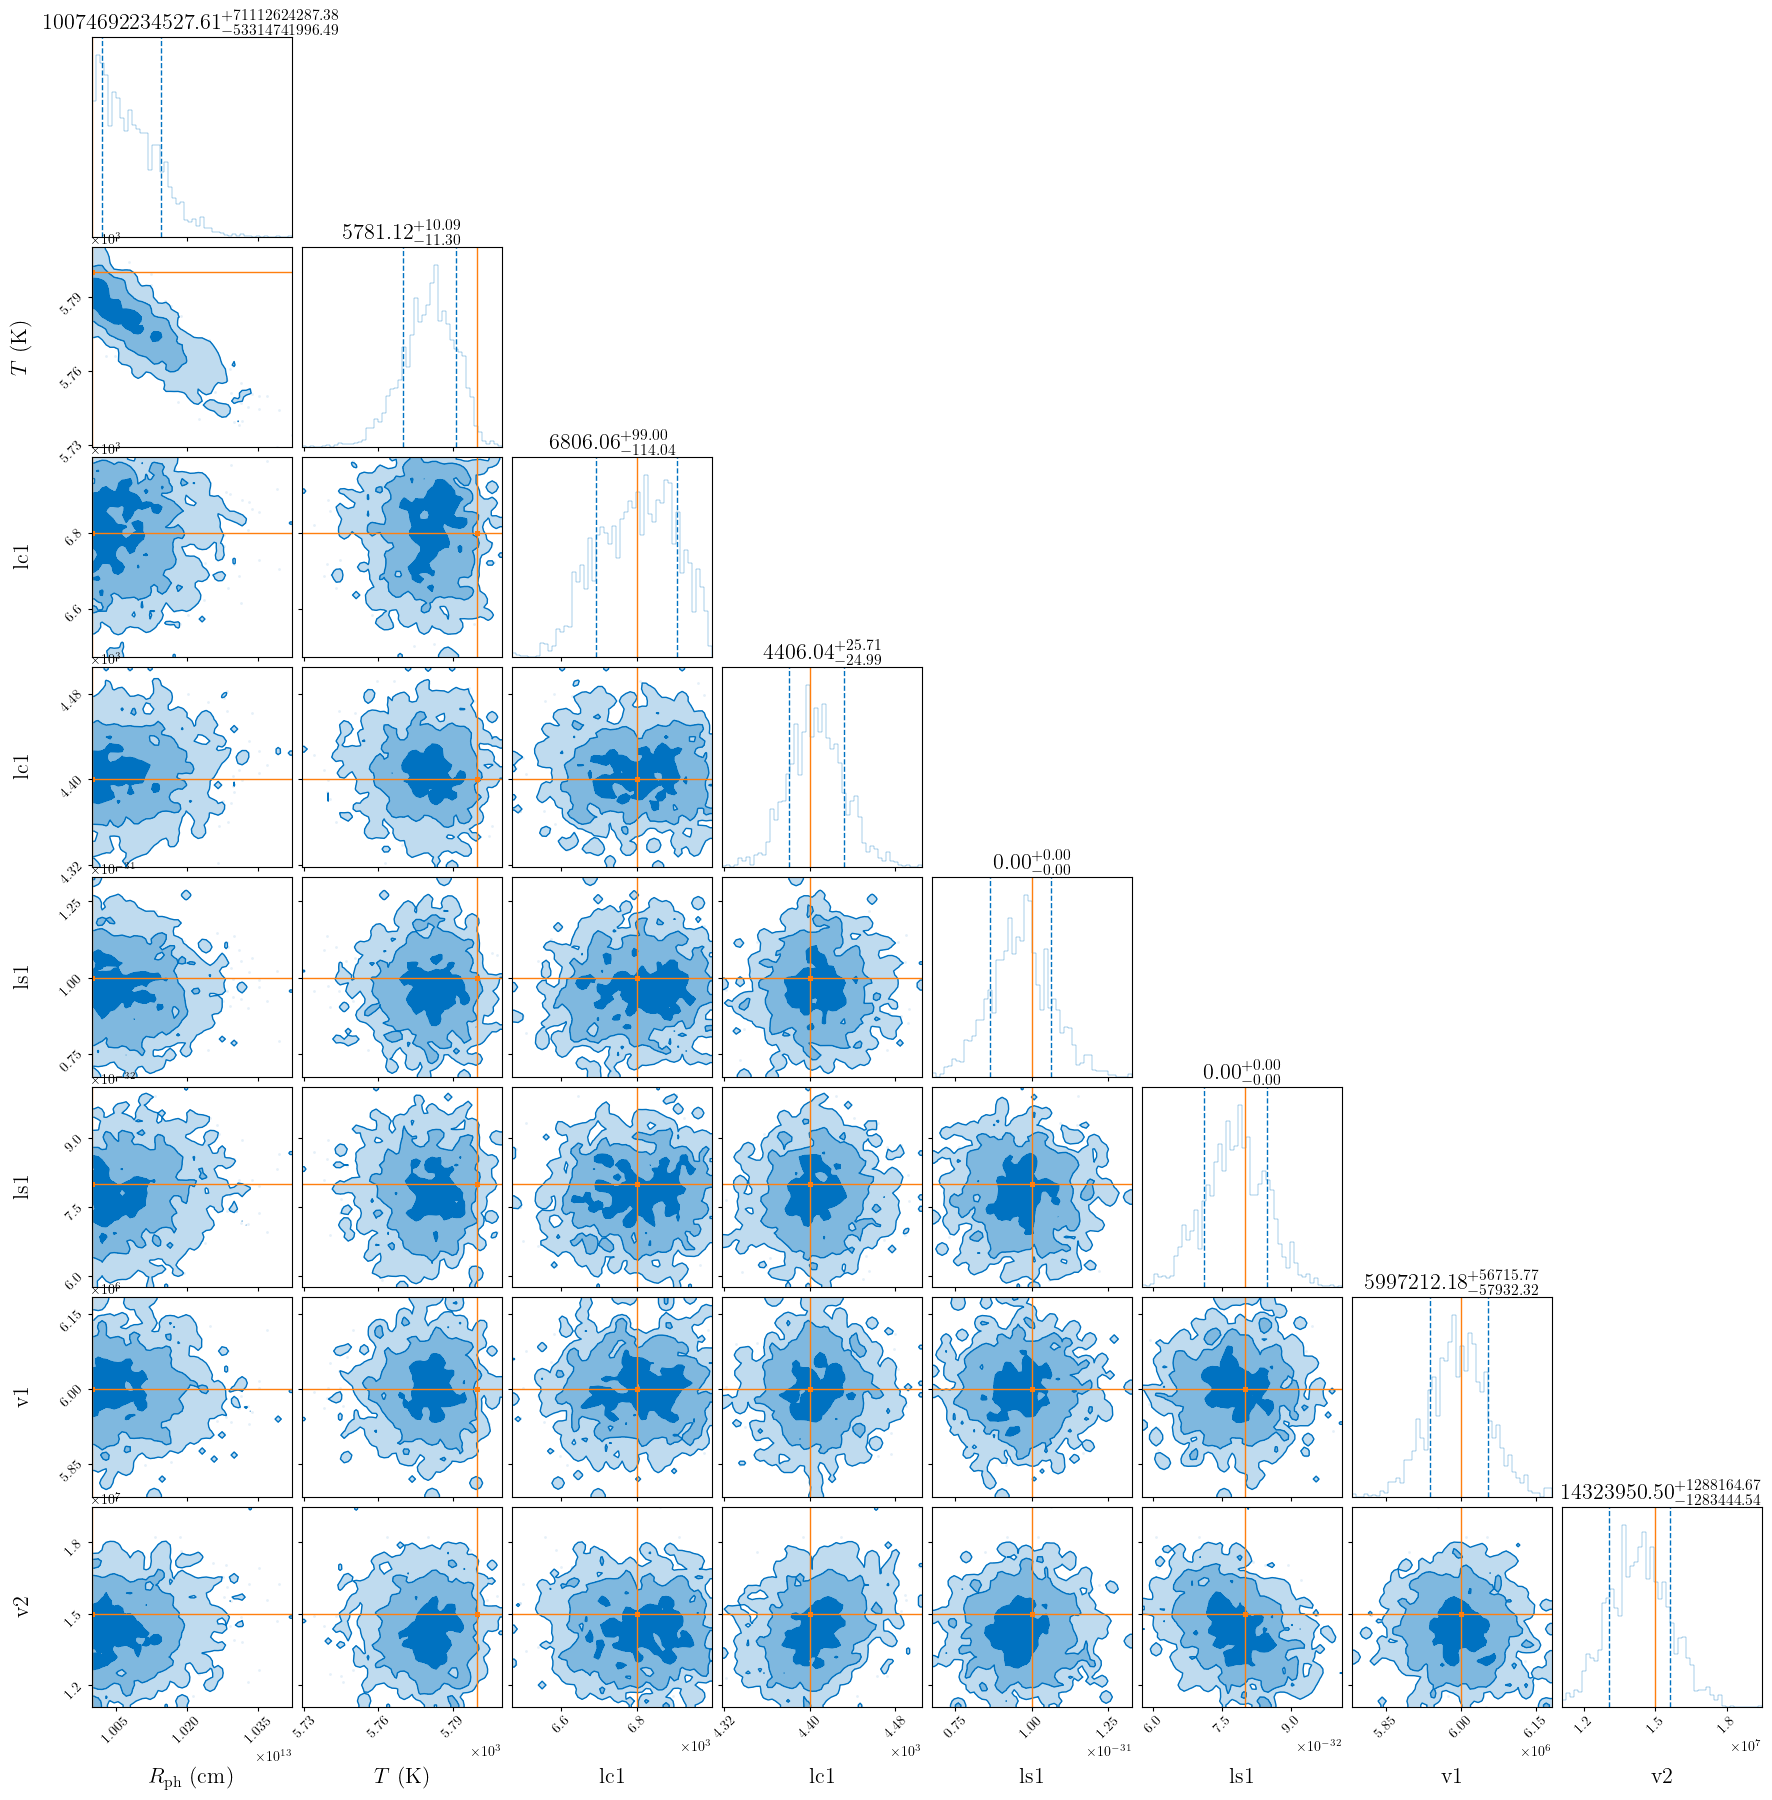

In [12]:
result.plot_corner()

We can also plot a residual plot, which will plot the lightcurve fit on one panel and the residual between the maximum likelihood and data underneath

(3000.0, 9000.0)

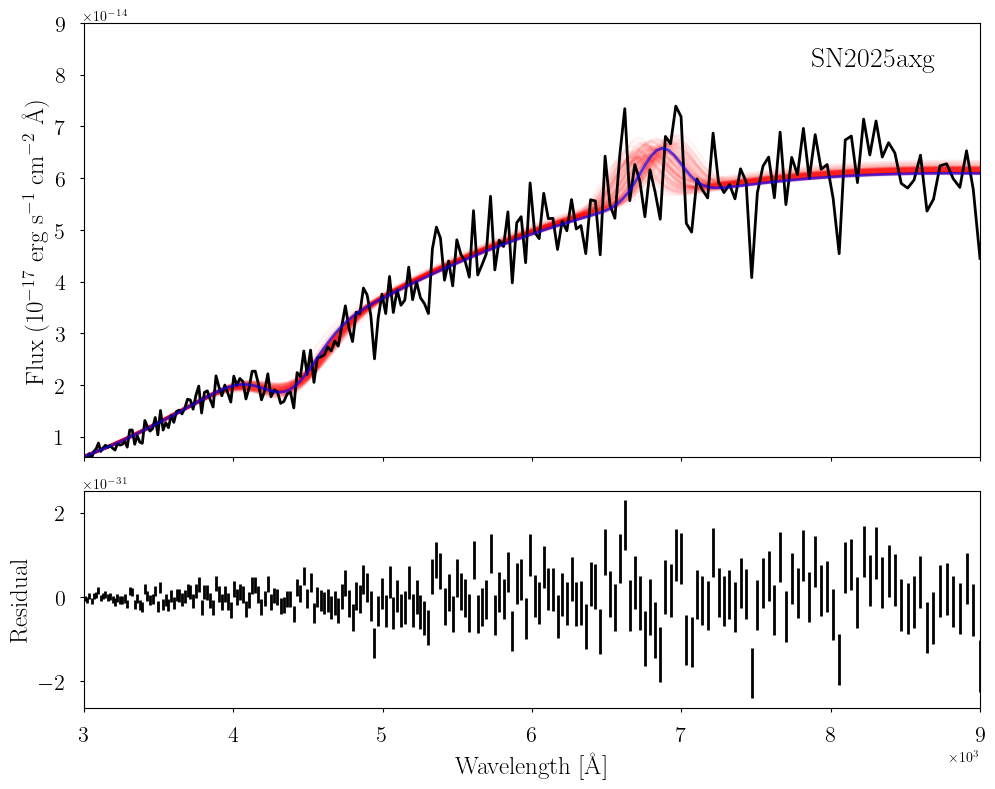

In [15]:
ax = result.plot_residual(yscale='linear', ylim_low=6e-15, 
                    ylim_high=9e-14,color='black', show=False)
ax[0].set_xlim(3000, 9000)
ax[1].set_xlim(3000, 9000)

This was just a general example of what you can do with spectrums with redback. Some additional plotting functionality is enabled via the Analysis class. You could jointly fit multiple spectrums or lightcurve and spectrums together, have a look in the docs or examples and play around!